**What tags generate the most views?**

In [1]:
## Imports for the whole section
import pandas as pd
from matplotlib import pyplot as plt
import json
import networkx as nx

In [2]:
## Read in data about tags
ted_main = pd.read_csv('data/ted_main.csv')
tags_deets = dict() # Dictionary containing tags as keys and total views, frequency tag is used as values

## Get all tags and their views and freq
# Loop through each talk and get/set tags data
for i in range(len(ted_main)):
    views = int(ted_main['views'][i]) # total views for that talk
    string_tags = [t.strip() for t in ted_main['tags'][i].strip().lower().replace("'", "")[1:-1].split(',')] # Array of tags for that talk
    for tag in string_tags:
        if tag not in tags_deets:
            tags_deets[tag] = {'views':0, 'freq':0, 'avg':0}
        # Set values for that tag
        tags_deets[tag]['views'] += views
        tags_deets[tag]['freq'] += 1

## Get average values for all tags *regardless of frequency*
tag_avg = {k:tags_deets[k]['views']/float(tags_deets[k]['freq']) for k in tags_deets.keys()}        

In [3]:
## Get top 10 averages of all keys
top_views = list()
for key, value in sorted(tag_avg.iteritems(), key=lambda (k,v): (v,k)):
    top_views.append([key, value])
top_views.reverse()
## Print out results
print "Tags with highest average views\n"
for i, (key, value) in enumerate(top_views):
    if i > 9: break
    print str(i+1) + ".) " + key + ": " + str(round(value, 2))

Tags with highest average views

1.) body language: 7993455.09
2.) testing: 6657858.0
3.) success: 6454556.61
4.) introvert: 6303975.6
5.) mindfulness: 4335876.6
6.) evil: 4283967.0
7.) dance: 4122717.16
8.) productivity: 4048263.35
9.) addiction: 4033930.2
10.) magic: 4021694.06


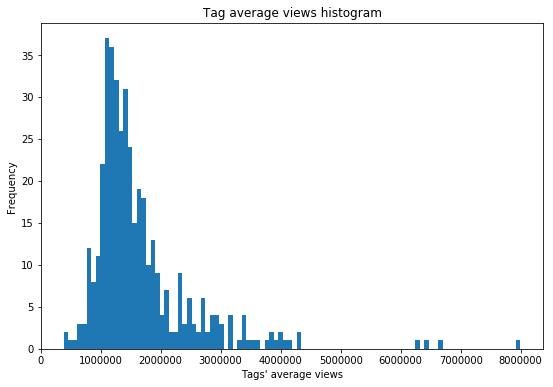

In [4]:
## Create histogram for the data
top_view_values = [top_views[i][1] for i in range(len(top_views))]
plt.figure(figsize=(9, 6))
plt.hist(top_view_values, 100)
plt.xlabel("Tags' average views")
plt.ylabel("Frequency")
plt.title("Tag average views histogram")
plt.show()

In [5]:
## Filter for tags that have a minimum of 5 different speeches
top_views_filtered = list()
filter_value = 5
for key, value in top_views:
    if tags_deets[key]['freq'] < filter_value: continue
    top_views_filtered.append([key, value])
## Print out results
print "Tags with highest average views with at least " + str(filter_value) + " tag instances\n"
for i, (key, value) in enumerate(top_views_filtered):
    if i > 9: break
    print str(i+1) + ".) " + key + ": " + str(round(value, 2))

Tags with highest average views with at least 5 tag instances

1.) body language: 7993455.09
2.) success: 6454556.61
3.) introvert: 6303975.6
4.) mindfulness: 4335876.6
5.) dance: 4122717.16
6.) productivity: 4048263.35
7.) addiction: 4033930.2
8.) magic: 4021694.06
9.) time: 3893878.59
10.) work-life balance: 3873959.5


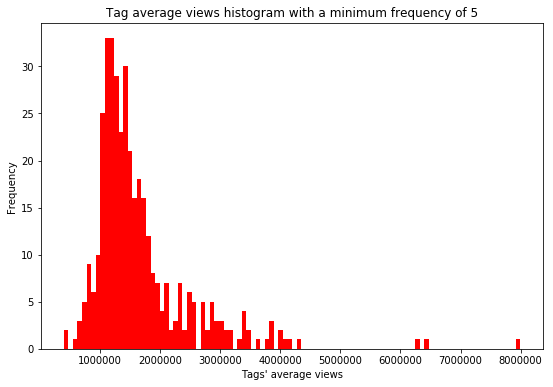

In [6]:
## Create another histogram
top_view_values_filtered = [top_views_filtered[i][1] for i in range(len(top_views_filtered))]
plt.figure(figsize=(9, 6))
plt.hist(top_view_values_filtered, 100, color="red")
plt.xlabel("Tags' average views")
plt.ylabel("Frequency")
plt.title("Tag average views histogram with a minimum frequency of " + str(filter_value))
plt.show()

Graph quick statistics
    Total nodes: 416
    Total edges: 22149
    Avg edge/node: 53.24


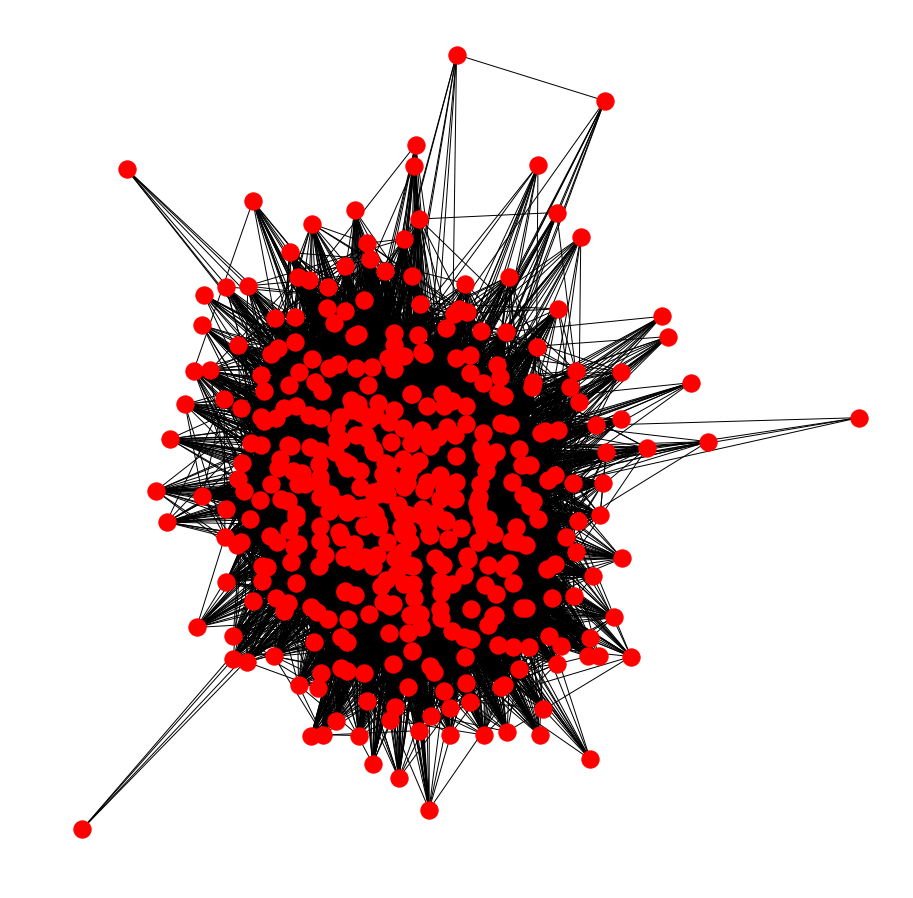

In [7]:
## Create network connecting tags
# an individual tag will be the nodes
# the edges will connect nodes if they appear in the same talk
tag_graph = nx.Graph()
# Make all nodes and then add edges
for i in range(len(ted_main)):
    # Properly format all tags from that talk into an array
    string_tags = [t.strip() for t in ted_main['tags'][i].strip().lower().replace("'", "")[1:-1].split(',')] # Array of tags for that talk
    # Add all tags as nodes to the graph
    tag_graph.add_nodes_from(string_tags)
    # Add edges for each tag to every other tag in that group
    for tag in string_tags:
        edges = [(tag, t) for t in string_tags if t != tag]
        tag_graph.add_edges_from(edges)
# Print stats about graph
print "Graph quick statistics"
print "    Total nodes: " + str(len(tag_graph.nodes))
print "    Total edges: " + str(len(tag_graph.edges))
print "    Avg edge/node: " + str(round(float(len(tag_graph.edges))/len(tag_graph.nodes), 2))

# Plot graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(tag_graph)
nx.draw(tag_graph, pos=pos)
plt.show()

In [8]:
## Print most connected tags out
top = 10
new_graph = list(reversed(sorted([(v,t) for t,v in nx.degree(tag_graph)])))
print "Most connected tags\n"
for i in range(top):
    print str(i+1) + ".) " + new_graph[i][1] + ": " + str(new_graph[i][0])

Most connected tags

1.) technology: 370
2.) tedx: 365
3.) science: 354
4.) innovation: 335
5.) global issues: 335
6.) society: 316
7.) culture: 316
8.) collaboration: 312
9.) future: 311
10.) humanity: 305


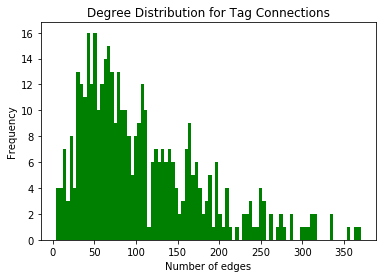

In [9]:
## Print out distribution of edges for hub detection
connections = [t[1] for t in nx.degree(tag_graph)]
plt.hist(connections, 90, color="green")
plt.title("Degree Distribution for Tag Connections")
plt.ylabel("Frequency")
plt.xlabel("Number of edges")
plt.show()

**Is there a formula for getting the most views?**

Regression model for bag of tags and other feature:
    Lasso regression - L1 re

In [10]:
import nltk
import pandas as pd
import numpy as np
# First get a list of all words in all descriptions that aren't stop words
stopwords = nltk.corpus.stopwords.words('english') 
ted_main = pd.read_csv('data/ted_main.csv')
all_words = set()
for i in range(len(ted_main)):
    talk_descript = [x for x in ted_main['description'][i].replace('(', '').replace(')', '').split(' ') if x != '']
    for word in talk_descript:
        if word.decode('utf-8') in stopwords:
            continue
        else:
            all_words.add(word)
# Convert to list
all_words = list(all_words)

In [11]:
# Construct np array to keep track of bag of words
views = list()
bag_of_words = np.zeros([len(ted_main), len(all_words)]) # last column is the views
# Loop through each speech and add up the words and get the views
for i in range(len(ted_main)):
    views.append(ted_main['views'][i])
    talk_descript = [x for x in ted_main['description'][i].replace('(', '').replace(')', '').split(' ') if x != '']
    for j, word in enumerate(all_words):
        bag_of_words[i][j] = talk_descript.count(word)

In [12]:
from sklearn import linear_model
# Do a Lasso regression with number of views
clf = linear_model.Lasso(alpha=0.1)
clf.fit(bag_of_words, views)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
# Allow for input from user
t = raw_input('Enter a description for your talk: ').rstrip().replace('(', '').replace(')', '').split(' ')
X = [list()]
for j, word in enumerate(all_words):
    X[0].append(t.count(word))
print "A talk with this description would get an estimated " + str(int(clf.predict(X))) + " views!"

** Recommender System **

Describe it here

In [ ]:
#!/usr/bin/env python2.7
import pandas as pd
import ast # converts string to dict
from afinn import Afinn # Sentiment score
import sys
'''
How we're going to rate recommendations:
1. Likes and dislikes on similar talks ~ everyone starts out with 0
2. get sentiment score on each rating and multiply it by the number of ratings
Keep track of speeches that have already been recommended and change ratings 
based on ratings of similar talks
'''

## Initialize dictionary for all talks
# Reads in all talks and scores their ratings
def init():
    ## Get tags user may want to listen to before
    user_tags = raw_input("Enter tags to describe the kinds of speeches you want to listen to: ").rstrip().split(' ')
    ## Read in data about tags
    ted_main = pd.read_csv('data/ted_main.csv')
    pq = dict()
    afinn = Afinn()
    ## Get all tags and their views and freq
    # Loop through each talk and get/set tags data
    for i in range(len(ted_main)):
        ratings =  ast.literal_eval(ted_main['ratings'][i])
        title = ted_main['title'][i]
        # Add user input to the order
        t_score = 0
        for t in user_tags:
            if t in ted_main['tags'][i]:
                t_score += 1
        # Get the sentiment score for all the ratings and multiply it by the number of times its said
        r_score = 0
        for rating in ratings:
            r_score += afinn.score(rating['name']) * rating['count']
        pq[title] = [t_score, r_score, 0]
    return pq

## Converts the dictionary of talks into a sorted list of just the titles
def get_list(pq_dict):
    pq = list()
    for key in pq_dict:
        pq.append([pq_dict[key][0], pq_dict[key][1], key])
    pq.sort(reverse=True)
    return [p[2] for p in pq]

## Set up dictionary of related talks
def set_related_talks():
    ## Read in data about tags
    ted_main = pd.read_csv('data/ted_main.csv')
    related_talks = dict()
    ## Get all tags and their views and freq
    # Loop through each talk and get/set tags data
    for i in range(len(ted_main)):  
        titles = [talk['title'] for talk in ast.literal_eval(ted_main['related_talks'][i])]
        related_talks[ted_main['title'][i]] = titles
    return related_talks

## Main execution block
def main():
    ## Init the priority queue, it'll come sorted
    pq_talks = init()
    related_talks = set_related_talks()
    pq_list = get_list(pq_talks)
    ## Read input
    # Continue to loop until everything is gone
    while True:
        while True:
            print "Enter 0 for the next rec\nEnter 1 to rate a Ted talk"
            inp = input()
            if inp == 0 or inp == 1:
                break
        # React to users choice
        if inp == 0:
            # Find first recommendation that hasnt already been rec'd
            index = 0
            for i in range(len(pq_talks)):
                if pq_talks[pq_list[i]][2] == 0:
                    index = i
                    break
            print "We recommend you listen to '" + pq_list[index] + "'"
            # Mark title as recommended
            pq_talks[pq_list[index]][2] = 1
            # Get user feedback
            while True:
                print "Do you want to listen to this? Enter 1 for yes, Enter -1 for no"
                rating = input()
                if rating == -1 or rating == 1:
                    break
            # Update that talks rating
            pq_talks[pq_list[index]][0] += rating
            # Now update rating for all of its related talks
            for talk in related_talks[pq_list[index]]:
                pq_talks[talk][0] += rating
        else:
            # Get rating for a speech the user already listened to
            print "Enter the title of the talk:"
            talk = raw_input().rstrip()
            # Validity check
            while talk not in pq_talks:
                print "Talk not found"
                talk = raw_input().rstrip()
            print "Did you like it? Enter 1 for yes, Enter -1 for no"
            rating = input()
            while rating != -1 and rating != 1:
                print "Error try again"
                rating = input()
            # Update rating and mark as listened to
            pq_talks[talk][2] = 1
            pq_talks[talk][0] += rating
            # Now flag all of its related talks here
            for t in related_talks[talk]:
                pq_talks[t][0] += rating
        # Reset list with updated information
        pq_list = get_list(pq_talks)

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        pass